In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## load data

In [4]:
company = 'AAPL'
company2 = 'GOOG'

yf.pdr_override()
start = dt.datetime(2000,1,1)
end = dt.datetime(2020,1,1)

In [6]:
data = yf.download(company,start,end)
data.to_csv(f"{company}_data.csv")
data2 = yf.download(company2,start,end)
data2.to_csv(f"{company2}_data.csv")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
data = pd.read_csv(f"{company}_data.csv")
data2 = pd.read_csv(f"{company2}_data.csv")

In [7]:
data2

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...,...
3864,2019-12-24,67.425003,67.513000,67.139000,67.178001,67.178001,6950000
3865,2019-12-26,67.308502,68.066353,67.223503,68.019997,68.019997,13350000
3866,2019-12-27,68.149498,68.226501,67.465500,67.594498,67.594498,20768000
3867,2019-12-30,67.500000,67.650002,66.700996,66.806999,66.806999,21018000


NameError: name 'x_train' is not defined

## data preprocessing

In [8]:
prediction_days = 80

x_train = []
y_train = []

scaler = MinMaxScaler(feature_range=(0,1))

    
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1,1))

for x in range(prediction_days,len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))



In [17]:
x_train.shape


(4951, 80, 1)

In [13]:
model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam",loss='mean_squared_error')

model.fit(x_train,y_train,epochs=15, batch_size=48)


Epoch 1/15
104/104 [==============================] - 5s 22ms/step - loss: 0.0037
Epoch 2/15
104/104 [==============================] - 2s 19ms/step - loss: 9.0909e-04
Epoch 3/15
104/104 [==============================] - 2s 19ms/step - loss: 8.6246e-04
Epoch 4/15
104/104 [==============================] - 2s 19ms/step - loss: 7.0470e-04
Epoch 5/15
104/104 [==============================] - 2s 19ms/step - loss: 7.5567e-04
Epoch 6/15
104/104 [==============================] - 2s 19ms/step - loss: 6.6153e-04
Epoch 7/15
104/104 [==============================] - 2s 19ms/step - loss: 6.3925e-04
Epoch 8/15
104/104 [==============================] - 2s 19ms/step - loss: 7.1111e-04
Epoch 9/15
104/104 [==============================] - 2s 19ms/step - loss: 6.1021e-04
Epoch 10/15
104/104 [==============================] - 2s 19ms/step - loss: 6.5006e-04
Epoch 11/15
104/104 [==============================] - 2s 19ms/step - loss: 5.2461e-04
Epoch 12/15
104/104 [==============================] - 2

## model accuracy test

In [18]:
test_start = dt.datetime(2015,1,1)
test_end = dt.datetime.now()
company = "TSLA"
test_data = yf.download(company,test_start,test_end)

[*********************100%%**********************]  1 of 1 completed


In [19]:
actual_prices = test_data["Close"].values

total_dataset = pd.concat([data["Close"],test_data['Close']],ignore_index=True)


model_inputs = total_dataset[len(total_dataset) - len(test_data)-prediction_days:].values


model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

## predictions

In [23]:
x_test = []

for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

print(x_test.shape)
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


(2287, 80, 1)


array([[ 71.118225],
       [ 69.10116 ],
       [ 64.55931 ],
       ...,
       [175.55685 ],
       [173.77927 ],
       [172.3118  ]], dtype=float32)

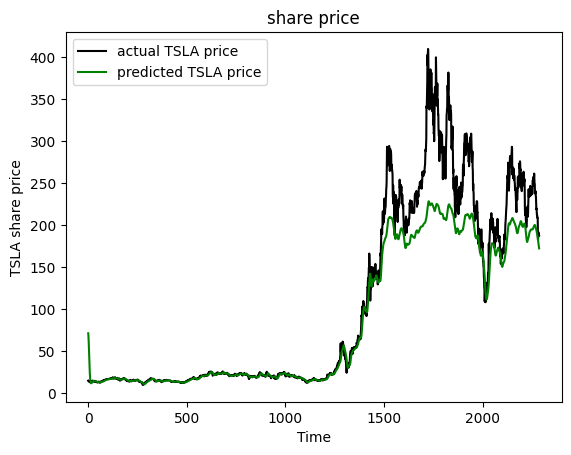

In [24]:
plt.plot(actual_prices,color="black", label=f"actual {company} price")
plt.plot(predicted_prices, color="green", label= f"predicted {company} price")
plt.title("share price")
plt.xlabel('Time')
plt.ylabel(f'{company} share price')
plt.legend()
plt.show()

## predict next day


In [26]:
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))

In [27]:
scaler.inverse_transform(model_inputs[-1].reshape(-1,1))

array([[187.91000366]])

In [28]:
prediction = model.predict(real_data[:len(real_data-1)])
prediction = scaler.inverse_transform(prediction)
print(f'prediction: {prediction}')

prediction: [[171.14682]]


In [29]:
actual_prices
predicted_prices

array([[ 71.118225],
       [ 69.10116 ],
       [ 64.55931 ],
       ...,
       [175.55685 ],
       [173.77927 ],
       [172.3118  ]], dtype=float32)

In [30]:
df = pd.DataFrame(data={"actual": actual_prices.reshape(-1),"predicted":predicted_prices.reshape(-1)} )

In [31]:
df['diff'] = df["actual"] - df["predicted"]

In [32]:
df['actual_comparison'] = ''

# Iterate over rows and compare with the previous row
for i in range(1, len(df)):
    if df['actual'].iloc[i] > df['actual'].iloc[i - 1]:
        df.at[i, 'actual_comparison'] = 'Higher'
    elif df['actual'].iloc[i] < df['actual'].iloc[i - 1]:
        df.at[i, 'actual_comparison'] = 'Lower'

In [33]:
df['predicted_comparison'] = ''

# Iterate over rows and compare with the previous row
for i in range(1, len(df)):
    if df['predicted'].iloc[i] > df['predicted'].iloc[i - 1]:
        df.at[i, 'predicted_comparison'] = 'Higher'
    elif df['predicted'].iloc[i] < df['predicted'].iloc[i - 1]:
        df.at[i, 'predicted_comparison'] = 'Lower'

In [34]:
df["accurate"] = df["actual_comparison"] == df["predicted_comparison"]

In [35]:
df.groupby("accurate").count()

,actual,predicted,diff,actual_comparison,predicted_comparison
accurate,,,,,
False,1089,1089,1089,1089,1089
True,1198,1198,1198,1198,1198


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [8]:
merged_data


,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Adj Close_AAPL,Volume_AAPL,Open_BA,High_BA,Low_BA,Close_BA,Adj Close_BA,Volume_BA,Company
Date,,,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.466448,212818400,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,Apple
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.777191,257142000,14.303333,14.433333,13.810667,14.006000,14.006000,80527500,Apple
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.779427,263188400,14.004000,14.280000,13.614000,14.085333,14.085333,93928500,Apple
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.112869,160423600,14.223333,14.318667,13.985333,14.063333,14.063333,44526000,Apple
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.039337,237458000,14.187333,14.253333,14.000667,14.041333,14.041333,51637500,Apple
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,69.236244,48478800,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,Boeing
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.609901,93121200,28.527332,28.898666,28.423332,28.729334,28.729334,159508500,Boeing
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.583115,146266000,29.000000,29.020666,28.407333,28.691999,28.691999,149185500,Boeing
